# Recommender Systems 2020/21

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "data/Movielens_10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)
    
dataFile = zipfile.ZipFile(data_file_name)
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path="data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)


In [2]:
def list_ID_stats(ID_list, label):
    
    min_val = min(ID_list)
    max_val = max(ID_list)
    unique_val = len(set(ID_list))
    missing_val = 1 - unique_val/(max_val - min_val)

    print("{} data, ID: min {}, max {}, unique {}, missig {:.2f} %".format(label, min_val, max_val, unique_val, missing_val*100))

    
    
list_ID_stats(userList, "User")
list_ID_stats(itemList, "Item")

User data, ID: min 1, max 71567, unique 69878, missig 2.36 %
Item data, ID: min 1, max 65133, unique 10677, missig 83.61 %


In [3]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()

### For items in particular most have no interactions. Sometimes it may be better to remove them to avoid creating big data structures with no need. In this case empty columns will nave no impact and we leave them as is. 

## And now load the content informations in the same way:
## In this case we are using tags

In [4]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)


In [5]:
list_ID_stats(userList_icm, "Users ICM")
list_ID_stats(itemList_icm, "Items ICM")

Users ICM data, ID: min 15, max 71556, unique 4009, missig 94.40 %
Items ICM data, ID: min 1, max 65130, unique 7601, missig 88.33 %


### We can see that most users and items have no data associated to them

In [6]:
numTags = len(set(tagList_icm))

print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])

Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


### The numbers of items and users in the ICM matrix is different from what we saw in the URM, why?

### The tags are string, we should traslate them into numbers so we can use them as indices in the ICM

In [7]:
from sklearn import preprocessing
ICM_label_encoder = preprocessing.LabelEncoder()
ICM_label_encoder.fit(tagList_icm)

tagList_icm = ICM_label_encoder.transform(tagList_icm)

print(tagList_icm[0:10])

[ 9814 13375 14131  8515 10769 14070  7015  8071 14829 14900]


# We can now build the ICM

#### Be careful with the indices!

In [8]:
import numpy as np

n_items = URM_all.shape[1]
n_tags = max(tagList_icm) + 1

ICM_shape = (n_items, n_tags)

ones = np.ones(len(tagList_icm))
ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape = ICM_shape)
ICM_all = ICM_all.tocsr()

ICM_all

<65134x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

### We leverage CSR and CSC indptr data structure to compute the number of cells that have values for that row or column

In [9]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [10]:
print(features_per_item.shape)
print(items_per_feature.shape)

(65134,)
(16529,)


In [11]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

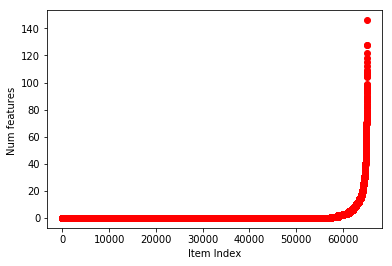

In [12]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Item Index')
pyplot.show()

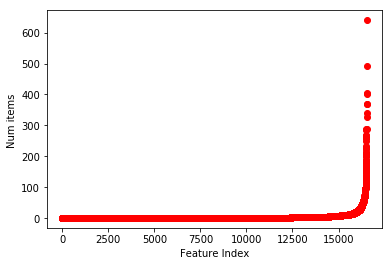

In [13]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Feature Index')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [14]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


In [15]:
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

### We need to define Cosine similarity... Let's look at the attached source code

### See also a [list of commonly used KNN similarity heuristics](https://github.com/MaurizioFD/RecSys_Course_2018/blob/master/slides/List_of_KNN_similarity_heuristics.pdf)

## A KNN is built with the following steps:
* Compute the similarity of an item with all others
* Select the k-highest similarities

In [16]:
item_id = 50
shrink = 10

The numerator is the dot product of the item features times the whole ICM data transposed

In [17]:
numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
numerator_vector

array([0., 7., 0., ..., 0., 0., 0.])

In [18]:
item_norms = np.sqrt(np.array(ICM_all.T.power(2).sum(axis=0))).ravel()
item_norms

array([ 0.        , 31.43246729, 10.81665383, ...,  0.        ,
        0.        ,  0.        ])

The denominator will be the product of norms plus the srink term and a small value which prevents the denominator to be zero (only for non-negative data)

In [19]:
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6
denominator_vector

array([ 10.000001  , 810.75714271, 285.55943198, ...,  10.000001  ,
        10.000001  ,  10.000001  ])

In [20]:
similarity_vector = numerator_vector/denominator_vector

Let's sort the similarity from the highest to the lowest

In [21]:
sorted_item_indices = np.argsort(-similarity_vector)
sorted_item_indices

array([   50,  6187,  1625, ..., 22743, 22745, 65133], dtype=int64)

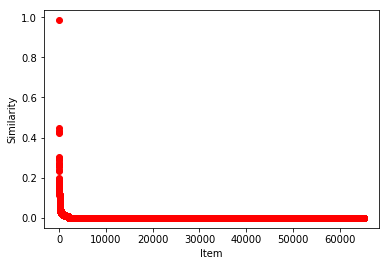

In [22]:
pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

Now we select the k most similar items

In [23]:
k = 100

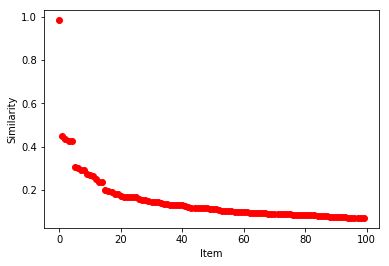

In [24]:
pyplot.plot(similarity_vector[sorted_item_indices[0:k]], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

The operation is performed for all items.
A simple strategy to perform it efficiently is to vectorize the most computationally intensive part, the dot product, on a group of items. The speedup can be of a factor of 10-100.
This strategy is limited by the fact that the result of the dot product is a huge item-item dense similarity which likely does not fit in memory.

In [25]:
import traceback

try:
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
except Exception as e:
    traceback.print_exc()
    

Traceback (most recent call last):
  File "<ipython-input-25-898ccb95d904>", line 4, in <module>
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
  File "C:\ProgramData\Anaconda3\envs\DLevaluation_cpu\lib\site-packages\scipy\sparse\compressed.py", line 962, in toarray
    out = self._process_toarray_args(order, out)
  File "C:\ProgramData\Anaconda3\envs\DLevaluation_cpu\lib\site-packages\scipy\sparse\base.py", line 1187, in _process_toarray_args
    return np.zeros(self.shape, dtype=self.dtype, order=order)
MemoryError


The solution is:
* Compute the numerator a block of items at a time leveraging vectorization while not running out of memory
* Extract the k-nn on those items
* Built incrementally the sparse similarity matrix

In [26]:
block_size = 100

numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
numerator_block.shape

(100, 65134)

Let's compare the speed to compute the dot product on the whole similarity of the two strategies

In [27]:
import time

n_items = ICM_all.shape[0]

start_time = time.time()

for n_item in range(n_items):
    numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
    
end_time = time.time()

print("Computing the similarity one item at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity one item at a time runs at 808.38 items/sec


In [28]:
n_items = ICM_all.shape[0]

start_time = time.time()

block_size = 100
blocks_start_positions = range(0, n_items, block_size)

for start_pos in blocks_start_positions:
    end_pos = min(start_pos + block_size, n_items)
    
    numerator_block = ICM_all[start_pos:end_pos].dot(ICM_all.T).toarray()
    
end_time = time.time()

print("Computing the similarity in blocks of 100 items at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity in blocks of 100 items at a time runs at 55857.87 items/sec


### In this case the vectorized implementation runs >50 times faster!

#### Usually most of the speed gain comes with blocks of 100 or so items, depending on the system. Much higher than that tends to not be beneficial while requiring increasingly more memory.

Now an example of something you should *never* do, nested loops to compute the similarity of each item without vectorization

In [29]:
n_items = 100

start_time = time.time()

for n_item in range(n_items):
    for second_item in range(n_items):
        numerator_vector = ICM_all[item_id].dot(ICM_all[second_item].T)
    
end_time = time.time()

print("Computing the similarity with nested loops runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity with nested loops runs at 32.07 items/sec


You see how incredibly slow nested loops are compared to a well vectorized implementation

## Test our CBF recommender:

In [30]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 37400 ( 57 % ), 1243.45 column/sec, elapsed time 0.50 min
Similarity column 65134 ( 100 % ), 1254.02 column/sec, elapsed time 0.87 min


In [31]:
userList_unique = list(set(userList_icm))
for user_id in userList_unique[0:10]:
    print(recommender.recommend(user_id, at=5))

[8636 6333  153  592 2640]
[ 153 2001 1036 3984 6934]
[65133 21706 21719 21718 21717]
[ 1210  5618  2628 31658  6350]
[5651 2566 2043 8525 2052]
[65133 21706 21719 21718 21717]
[65133 21706 21719 21718 21717]
[1026 2566 2043 5651 8525]
[ 4901  5952  2628  1619 33679]
[65133 21706 21719 21718 21717]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [32]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 447.20 usr/sec


### Let's add a common mistake.... a CSC URM

In [33]:
URM_train_csc = URM_train.tocsc()

recommender = ItemKNNCBFRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 40100 ( 62 % ), 1333.30 column/sec, elapsed time 0.50 min
Similarity column 65134 ( 100 % ), 1292.27 column/sec, elapsed time 0.84 min


In [34]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()


Exception index 65135 is out of bounds for axis 0 with size 65134


Traceback (most recent call last):
  File "<ipython-input-34-cd8883de5544>", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "<ipython-input-15-88972fee293e>", line 25, in recommend
    scores = self.filter_seen(user_id, scores)
  File "<ipython-input-15-88972fee293e>", line 40, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 65135 is out of bounds for axis 0 with size 65134


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [36]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_dict[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
Similarity column 65134 ( 100 % ), 3801.45 column/sec, elapsed time 0.29 min
EvaluatorHoldout: Processed 37000 ( 53.01% ) in 30.66 sec. Users per second: 1207
EvaluatorHoldout: Processed 69793 ( 100.00% ) in 56.84 sec. Users per second: 1228
ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
Similarity column 65134 ( 100 % ), 3860.03 column/sec, elapsed time 0.28 min
EvaluatorHoldout: Processed 34000 ( 48.72% ) in 30.47 sec. Users per second: 1116
EvaluatorHoldout: Processed 68000 ( 97.43% ) in 1.01 min. Users per second: 1120
EvaluatorHoldout: Processed 69793 ( 100.00% ) in 1.04 min. Users per second: 1119
ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
Similarity column 65134 ( 100 % ), 3855.46 column/sec, ela

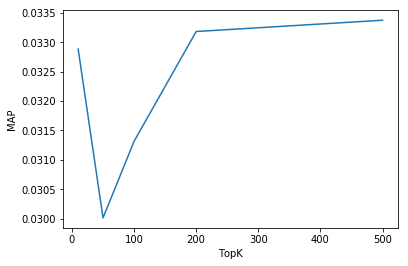

In [37]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [38]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_dict[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
Similarity column 65134 ( 100 % ), 3864.61 column/sec, elapsed time 0.28 min
EvaluatorHoldout: Processed 32000 ( 45.85% ) in 30.88 sec. Users per second: 1036
EvaluatorHoldout: Processed 64000 ( 91.70% ) in 1.02 min. Users per second: 1041
EvaluatorHoldout: Processed 69793 ( 100.00% ) in 1.12 min. Users per second: 1041
ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
Similarity column 65134 ( 100 % ), 3872.19 column/sec, elapsed time 0.28 min
EvaluatorHoldout: Processed 30000 ( 42.98% ) in 30.36 sec. Users per second: 988
EvaluatorHoldout: Processed 61000 ( 87.40% ) in 1.02 min. Users per second: 995
EvaluatorHoldout: Processed 69793 ( 100.00% ) in 1.17 min. Users per second: 995
ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83

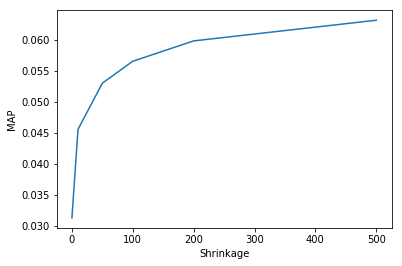

In [39]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a parameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

![title](https://www.link-assistant.com/images/news/tf-idf-tool-for-seo/screen-03.png)

In [40]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = (ICM_all > 0).sum(axis=0)

IDF = np.array(np.log(num_tot_items / items_per_feature))[0]

print(ICM_all.shape)
print(IDF.shape)

(65134, 16529)
(16529,)


In [41]:
IDF

array([11.08420197, 11.08420197, 11.08420197, ..., 11.08420197,
       11.08420197, 11.08420197])

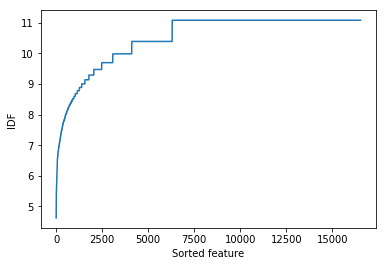

In [42]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

#### Highest ranked features

In [43]:
sorted_features = np.argsort(-IDF)

highest_ranked_features = sorted_features[:20]
ICM_label_encoder.inverse_transform(highest_ranked_features)

array(["!950's Superman TV show", 'edo', 'edulcorada', 'edward furlong',
       'edward r. murrow', 'effective and superfun monster movie.', 'egg',
       'eggs', 'ego', 'eh -  took me two watches to kinda like it',
       'edinburgh', 'ehh', 'ein grosses Film - ausgezeichnet!!',
       'electric shocks', 'electricity', 'electronics', 'elegant love',
       'elektra', 'elisabeth shue', 'elitism'], dtype='<U241')

#### Lowest ranked features

In [44]:
lowest_ranked_features = sorted_features[-20:]
ICM_label_encoder.inverse_transform(lowest_ranked_features)

array(['atmospheric', 'library', 'seen more than once',
       'Nudity (Topless - Brief)', 'To See', 'adapted from:book',
       'imdb top 250', "Can't remember", 'classic', 'Bibliothek',
       'Betamax', 'National Film Registry', 'movie to see',
       'Nudity (Topless)', 'based on a book', '70mm', 'R',
       "erlend's DVDs", 'less than 300 ratings', "Tumey's DVDs"],
      dtype='<U241')

In [45]:
ICM_idf = ICM_all.copy()
# compute the number of non-zeros in each col
# NOTE: this works only if X is instance of sparse.csc_matrix
col_nnz = np.diff(sps.csc_matrix(ICM_idf).indptr)
print(col_nnz.shape)
print(ICM_idf.shape)
print(IDF.shape)
# then normalize the values in each col
ICM_idf.data *= np.repeat(IDF, col_nnz)

(16529,)
(65134, 16529)
(16529,)


In [47]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_dict, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
Similarity column 65134 ( 100 % ), 3686.76 column/sec, elapsed time 0.29 min
EvaluatorHoldout: Processed 32000 ( 45.85% ) in 30.68 sec. Users per second: 1043
EvaluatorHoldout: Processed 65000 ( 93.13% ) in 1.02 min. Users per second: 1061
EvaluatorHoldout: Processed 69793 ( 100.00% ) in 1.10 min. Users per second: 1061


{'ROC_AUC': 0.2070265972459598,
 'PRECISION': 0.060348459014499645,
 'PRECISION_RECALL_MIN_DEN': 0.06441172751439454,
 'RECALL': 0.02643440671057219,
 'MAP': 0.030469758862055867,
 'MRR': 0.17211540407814582,
 'NDCG': 0.037953267883347984,
 'F1': 0.03676476218242007,
 'HIT_RATE': 0.6034845901451436,
 'ARHR': 0.2194381958076168,
 'NOVELTY': 0.0019159201316981819,
 'AVERAGE_POPULARITY': 0.1654790081669998,
 'DIVERSITY_MEAN_INTER_LIST': 0.946211790863206,
 'DIVERSITY_HERFINDAHL': 0.9946198233460732,
 'COVERAGE_ITEM': 0.06265544876715694,
 'COVERAGE_ITEM_CORRECT': 0.016627260724045814,
 'COVERAGE_USER': 0.9751984126984127,
 'COVERAGE_USER_CORRECT': 0.35609490274983235,
 'DIVERSITY_GINI': 0.006756776067309181,
 'SHANNON_ENTROPY': 8.84345118331692}

#### There is  a small gain over the non-weighted ICM. Try other feature weighting methods like BM25...

# BM25

In [48]:
from Base.IR_feature_weighting import okapi_BM_25

ICM_BM25 = ICM_all.copy().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsr()

In [49]:
recommender_bm25 = ItemKNNCBFRecommender(URM_train, ICM_BM25)
recommender_bm25.fit(shrink=0.0, topK=50)

result_dict, _ = evaluator_test.evaluateRecommender(recommender_bm25)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
Similarity column 65134 ( 100 % ), 3736.46 column/sec, elapsed time 0.29 min
EvaluatorHoldout: Processed 31000 ( 44.42% ) in 30.20 sec. Users per second: 1027
EvaluatorHoldout: Processed 64000 ( 91.70% ) in 1.02 min. Users per second: 1048
EvaluatorHoldout: Processed 69793 ( 100.00% ) in 1.11 min. Users per second: 1051


{'ROC_AUC': 0.20815472295738865,
 'PRECISION': 0.06190878741419806,
 'PRECISION_RECALL_MIN_DEN': 0.06621445071468135,
 'RECALL': 0.027672855561717478,
 'MAP': 0.030931849897542447,
 'MRR': 0.17181978499231793,
 'NDCG': 0.039659430508371146,
 'F1': 0.03824874997157121,
 'HIT_RATE': 0.619087874142106,
 'ARHR': 0.22060488851500742,
 'NOVELTY': 0.00194804685061512,
 'AVERAGE_POPULARITY': 0.16462713246053637,
 'DIVERSITY_MEAN_INTER_LIST': 0.9487980619695631,
 'DIVERSITY_HERFINDAHL': 0.9948784467510778,
 'COVERAGE_ITEM': 0.06515798200632542,
 'COVERAGE_ITEM_CORRECT': 0.01693432001719532,
 'COVERAGE_USER': 0.9751984126984127,
 'COVERAGE_USER_CORRECT': 0.361781801922647,
 'DIVERSITY_GINI': 0.007064402757753818,
 'SHANNON_ENTROPY': 8.902052000913166}

#### Another small gain over TF-IDF

# Unnormalized similarity matrix

In [50]:
recommender_dot = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

result_dict, _ = evaluator_test.evaluateRecommender(recommender_dot)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 1690 (2.36 %) cold users.
ItemKNNCBFRecommender: URM Detected 54523 (83.71 %) cold items.
EvaluatorHoldout: Processed 19000 ( 27.22% ) in 30.41 sec. Users per second: 625
EvaluatorHoldout: Processed 38000 ( 54.45% ) in 1.01 min. Users per second: 627
EvaluatorHoldout: Processed 57000 ( 81.67% ) in 1.52 min. Users per second: 627
EvaluatorHoldout: Processed 69793 ( 100.00% ) in 1.86 min. Users per second: 625


{'ROC_AUC': 0.3254914743348736,
 'PRECISION': 0.11686702104798023,
 'PRECISION_RECALL_MIN_DEN': 0.12451347624576094,
 'RECALL': 0.051125396743676214,
 'MAP': 0.06731911481276623,
 'MRR': 0.2935413259482405,
 'NDCG': 0.08068561452935788,
 'F1': 0.07113264867393673,
 'HIT_RATE': 1.168670210479561,
 'ARHR': 0.42350010541375344,
 'NOVELTY': 0.0014455765492946955,
 'AVERAGE_POPULARITY': 0.4957891156325233,
 'DIVERSITY_MEAN_INTER_LIST': 0.781303051769327,
 'DIVERSITY_HERFINDAHL': 0.9781291857193198,
 'COVERAGE_ITEM': 0.008628366137501151,
 'COVERAGE_ITEM_CORRECT': 0.003976417846286118,
 'COVERAGE_USER': 0.9751984126984127,
 'COVERAGE_USER_CORRECT': 0.5271769505924435,
 'DIVERSITY_GINI': 0.0007898098592797655,
 'SHANNON_ENTROPY': 6.06052068984684}